# Practical Work in AI: Enhancing item relevance scores with psychology-based interest over time for music recommender systems

Author: Laura Legat

Matriculation ID: 51868012

In [9]:
# import access to Google Drive files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# import needed libraries

import os
import torch
import sys
import pandas as pd
import importlib

!pip install optuna
import optuna
import pickle
import matplotlib.pyplot as plt
import json

!pip install tensorboardX

print('\nAll imports successful!')


All imports successful!


In [11]:
# Check if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_name = torch.cuda.get_device_name(device)
    print(f'Using GPU: {device_name}')
else:
    device = torch.device('cpu')
    print('Using CPU')

print(f'Current device: {device}')

# preprocessing: 2-3 mins ex2vec, 6-7 mins train, 1 min val, 1 min test
#training: epoch braucht 5mins bei gru4rec

Using GPU: NVIDIA L4
Current device: cuda


In [ ]:
# create train-val-test sets for Ex2Vec training, as well as sequences for GRU4Rec training
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/preprocess.py -sl 50 -st 1 -sm Y

Pre-processing dataset for Ex2Vec...
Saved processed.csv
Pre-processing dataset for GRU4Rec...
Saved sequenced files for GRU4Rec


In [12]:
# import custom code

# Append the directory containing 'data_sampler' and 'ex2vec' to Python's search path
sys.path.append('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI')

# imports modules for preparing data and for training/evaluating the ex2vec model
import data_sampler
from ex2vec import Ex2VecEngine

#import dir of gru4rec_pytorch module to python path in order to be able to access GRU4Rec model class to be able to load it
sys.path.append('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork')
import gru4rec_pytorch
import evaluation as GRUeval

In [ ]:
importlib.reload(data_sampler)
importlib.reload(gru4rec_pytorch)

The size of the training set is: 622821
The size of the validation set is: 88296
The size of the test set is: 179765


<module 'gru4rec_pytorch' from '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/gru4rec_pytorch.py'>

In [ ]:
# initial training + hyperparameter optimization with seq_train.csv and seq_val.csv on GRU4Rec

!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_train.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_GRU4Rec.json -nt 5 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/run.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec.json -mo gru4rec -t /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_val.csv -m "1 5 10 20" -ik "itemId" -tk "timestamp" -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_vis_gru4rec.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec.db" -sn "gru4rec_study1"

--------------------------------------------------------------------------------
PARAMETER SPACE:
	PARAMETER name=loss 	 type=categorical 	 options: [bpr-max,cross-entropy]
	PARAMETER name=constrained_embedding 	 type=categorical 	 options: [False,True]
	PARAMETER name=embedding 	 type=categorical 	 options: [0,64]
	PARAMETER name=elu_param 	 type=categorical 	 options: [0.5,1,0]
	PARAMETER name=layers 	 type=int 	 range=[64..64] (step=1) 	 UNIFORM scale
	PARAMETER name=n_epochs 	 type=categorical 	 options: [5,10,15]
	PARAMETER name=batch_size 	 type=int 	 range=[32..512] (step=16) 	 UNIFORM scale
	PARAMETER name=dropout_p_embed 	 type=float 	 range=[0.0..0.7] (step=0.05) 	 UNIFORM scale
	PARAMETER name=dropout_p_hidden 	 type=float 	 range=[0.0..0.7] (step=0.05) 	 UNIFORM scale
	PARAMETER name=learning_rate 	 type=float 	 range=[0.0001..0.1] (step=5e-05) 	 UNIFORM scale
	PARAMETER name=momentum 	 type=float 	 range=[0.0..0.9] (step=0.05) 	 UNIFORM scale
	PARAMETER name=n_sample 	 typ

In [ ]:
# combine seq_train and seq_val to seq_combined.csv for final training/eval

train_csv = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_train.csv')
val_csv = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_val.csv')

# remove header row from the second df
val_csv = val_csv.iloc[0:].reset_index(drop=True)

# stack rows of both csv's
combined_csv = pd.concat([train_csv, val_csv], ignore_index=True)

# Save the combined DataFrame
combined_csv.to_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_combined.csv', index=False)

In [13]:
# convert best parameters to parameter string
def convert_to_param_str(best_param_path):
  with open(best_param_path, 'r') as f:
    data = json.load(f)

  params = data['best_params'] # extract only the parameter part
  param_str = ','.join([f'{key}={value}' for key,value in params.items()])

  return param_str

In [ ]:
print(convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec.json'))

loss=cross-entropy,constrained_embedding=False,embedding=0,elu_param=1,layers=64,n_epochs=15,batch_size=240,dropout_p_embed=0.4,dropout_p_hidden=0.35000000000000003,learning_rate=0.07,momentum=0.05,n_sample=512,sample_alpha=0.7000000000000001,bpreg=1.35,logq=0.30000000000000004


In [ ]:
# retrain gru4rec with best params
"""
params: (from https://github.com/hidasib/GRU4Rec/blob/master/README.md)
  -t    Testset path
  -pf   Parameter file path
  -s    Path to save the state dict to
  -m    Calculate recall, MRR etc. at the given list length
  -ik   Item key
  -tk   Timestamp key
  -d    Device
"""

gru4rec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec.json')

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/run.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_combined.csv -ps {gru4rec_best_param_str} -t /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_test.csv -s /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams.pt -m 1 5 10 20 -d cpu -ik "itemId" -tk "timestamp" -pm recall -lpm'
get_ipython().system(command)

[1, 5, 10, 20]
Creating GRU4Rec model on device "cpu"
SET   loss                    TO   cross-entropy         (type: <class 'str'>)
SET   constrained_embedding   TO   False                 (type: <class 'bool'>)
SET   embedding               TO   0                     (type: <class 'int'>)
SET   elu_param               TO   1.0                   (type: <class 'float'>)
SET   layers                  TO   [64]                  (type: <class 'list'>)
SET   n_epochs                TO   15                    (type: <class 'int'>)
SET   batch_size              TO   240                   (type: <class 'int'>)
SET   dropout_p_embed         TO   0.4                   (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.35000000000000003   (type: <class 'float'>)
SET   learning_rate           TO   0.07                  (type: <class 'float'>)
SET   momentum                TO   0.05                  (type: <class 'float'>)
SET   n_sample                TO   512                   (type: <

In [ ]:
# training + hyperparameter optim ex2vec, without GRU4rec item embeddings

!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/processed.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_Ex2Vec.json -nt 5 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json -mo ex2vec -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_vis_ex2vec.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.db" -sn "teststudy_ex2vec"

--------------------------------------------------------------------------------
PARAMETER SPACE:
	PARAMETER name=BS 	 type=categorical 	 options: [512,1024,2048]
	PARAMETER name=num_epoch 	 type=categorical 	 options: [10,15]
	PARAMETER name=LR 	 type=float 	 range=[1e-05..0.001] (step=N/A) 	 LOG scale
	PARAMETER name=l2_regularization 	 type=float 	 range=[1e-05..0.01] (step=N/A) 	 LOG scale
--------------------------------------------------------------------------------
[I 2024-08-04 14:21:47,776] A new study created in RDB with name: teststudy_ex2vec
The size of the training set is: 622821
The size of the validation set is: 88296
The size of the test set is: 179765
Ex2Vec model is created with the following parameters for this run:

alias:ex2vec_BS512LR5e-05L_DIM64
num_epoch:10
batch_size:2048
optimizer:adam
adam_lr:3.96566531322033e-05
n_users:1750
n_items:879
latent_dim:64
num_negative:0
l2_regularization:0.00105248498111968
use_cuda:True
device_id:0
pretrain:False
pretrain_dir:/

In [ ]:
# training baseline ex2vec with best params
ex2vec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json')
print(ex2vec_best_param_str)

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -ps {ex2vec_best_param_str} -t N'
get_ipython().system(command)

BS=1024,num_epoch=10,LR=0.0005891454096711238,l2_regularization=0.00031071592807905906
The size of the training set is: 622821
The size of the validation set is: 88296
The size of the test set is: 179765
Ex2Vec model is created with the following parameters for this run:

alias:ex2vec_BS512LR5e-05L_DIM64
num_epoch:10
batch_size:1024
optimizer:adam
adam_lr:0.0005891454096711238
n_users:1750
n_items:879
latent_dim:64
num_negative:0
l2_regularization:0.00031071592807905906
use_cuda:True
device_id:0
pretrain:False
pretrain_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/Ex2Vec_pretrained.pt
model_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt
chckpt_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt
Ex2Vec(
  (user_lamb): Embedding(1750, 1)
  (user_bias): Embedding(1750, 1)
  (item_bias): Embedding(879, 1)
  (embedding_user): Embedding(1750, 64)
  (embedding_item): Embedding(87

In [ ]:
# training + hyperparameter optim ex2vec, with GRU4rec item embeddings
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/processed.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_Ex2Vec.json -nt 5 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec_gruembds.json -mo ex2vec -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_vis_ex2vec_gruembds.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec_gruembds.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec_gruembds.db" -sn "teststudy_ex2vec_gruembds"

In [ ]:
# re-train comparison model with best params
ex2vec_gruembds_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec_gruembds.json')
print(ex2vec_gruembds_best_param_str)

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -ps {ex2vec_gruembds_best_param_str} -t N -ep /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams.pt'
get_ipython().system(command)

<ipython-input-14-11bf373b9973>:10: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


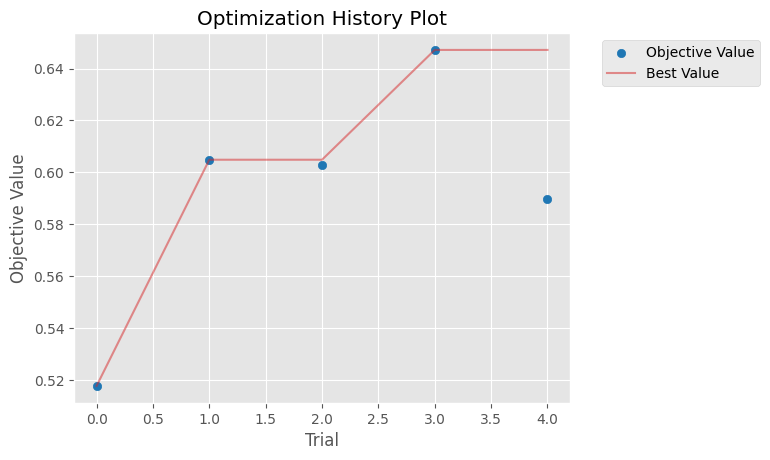

<ipython-input-14-11bf373b9973>:13: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


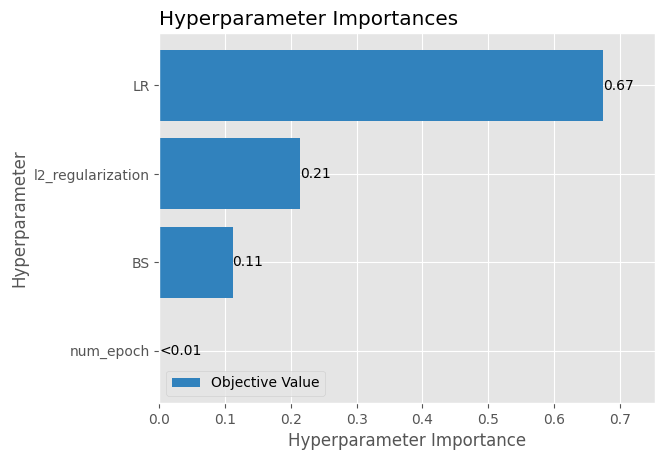

<ipython-input-14-11bf373b9973>:16: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)
/usr/local/lib/python3.10/dist-packages/optuna/visualization/matplotlib/_parallel_coordinate.py:135: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(dim.range[0], dim.range[1])


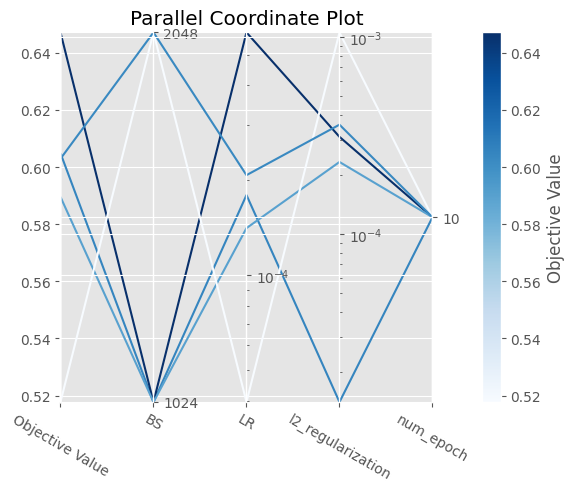

<ipython-input-14-11bf373b9973>:19: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/usr/local/lib/python3.10/dist-packages/optuna/visualization/matplotlib/_slice.py:162: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim[0], xlim[1])


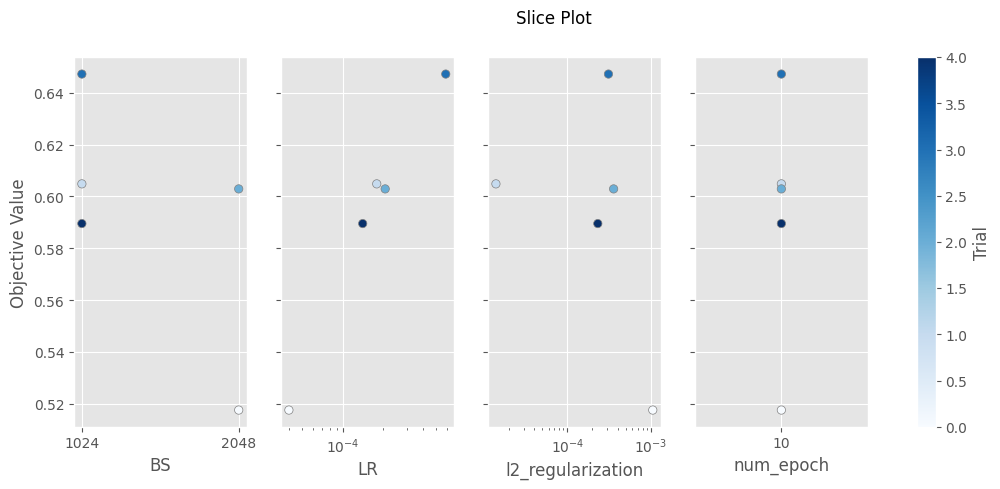

<ipython-input-14-11bf373b9973>:22: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf(study)


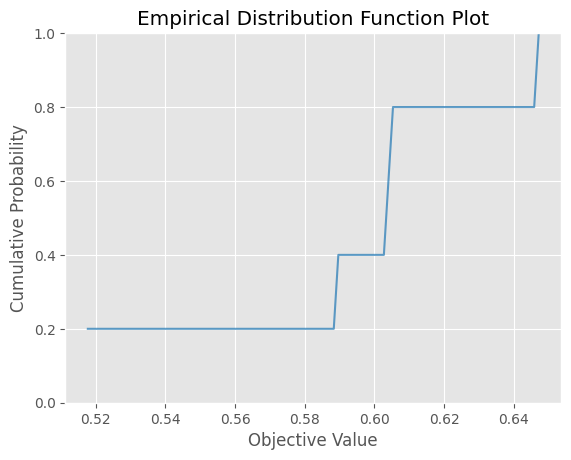

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_BS,params_LR,params_l2_regularization,params_num_epoch,state
0,0,0,0.517712,2024-08-04 14:21:47.788543,2024-08-04 14:24:38.098612,0 days 00:02:50.310069,2048,0.000040,0.001052,10,COMPLETE
1,1,1,0.604867,2024-08-04 14:24:38.145265,2024-08-04 14:27:23.301985,0 days 00:02:45.156720,1024,0.000180,0.000014,10,COMPLETE
2,2,2,0.602926,2024-08-04 14:27:23.348052,2024-08-04 14:30:11.589966,0 days 00:02:48.241914,2048,0.000208,0.000358,10,COMPLETE
3,3,3,0.647178,2024-08-04 14:30:11.628171,2024-08-04 14:32:57.893044,0 days 00:02:46.264873,1024,0.000589,0.000311,10,COMPLETE
4,4,4,0.589571,2024-08-04 14:32:57.929815,2024-08-04 14:35:43.903579,0 days 00:02:45.973764,1024,0.000141,0.000232,10,COMPLETE


In [14]:
# visualize optuna results for ex2vec
# Load study from pickle file
with open('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.pkl', 'rb') as f:
    study = pickle.load(f)

# Load trials data from CSV
trials_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_vis_ex2vec.csv')

# Optuna visualizations
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.show()

optuna.visualization.matplotlib.plot_slice(study)
plt.show()

optuna.visualization.matplotlib.plot_edf(study)
plt.show()

# Display the trials DataFrame
display(trials_df)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/runs